# Feed Forward Neural Network with Keras
> <span style="color:gray"> Created by Mikkel Vilstrup ([mvil](https://github.com/MVilstrup)) and 
Toke Faurby ([faur](https://github.com/Faur))
</span>


Pure TF is very verbose, and it is therefore a good idea to use a high-level API of some sort.
This simplifies and speeds-up development, reduces the risk of bugs, and generally reduces headache.
To handle this complexity various researchers and companies have gone in different directions with their frameworks.
Some have made it easier to explicitly state what you want, others have made it easier to quickly iterate over possible network structures.
There is no wrong or right here, just different implementations. 
Another neat benefit is that a lot of best practices (initialization, scoping, etc.) are hard-coded into the functions.

To showcase how different the implementations are, we have included this notebook to showcase **[Keras](https://keras.io/)**.
Keras is a high-level API that can use TensorFlow or Theano as backend.
It makes it really easy to try various configurations quickly.

In early 2017 [TensorFlow chose Keras](http://www.fast.ai/2017/01/03/keras/) as the first high-level API to include into the tensorflow core.
Keras has official Google support and has a large community and pre-existing examples.
Making it a good choice for high-level API to learn at the moment.
It is built on top of various backends, and can thus be utilized on top of almost all the other frameworks. 

Keras makes it easy to iterate over many standard building blocks, it makes it difficult too try to build new building blocks or experiment with small alterations of the standard building blocks specialized for your particular problem. 
Keras is however compatible with TF core, so you can easily create custom functionality when needed.

There several other high-level APIs: 
* [TFLearn](http://tflearn.org/),
* [tf.learn](https://www.tensorflow.org/get_started/tflearn) (yes, the names are confusing :( ),
* [tf.slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim), and
* [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers).

These are generally compatible with each other, and offer overlaping functionality.
This can be confusing.



#### External resources
If you wish to dig deeper into Keras have a look at:
* Tutorial: [Keras as a simplified interface to TensorFlow](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html)
* [Keras source code](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/keras) in the TF github repo. Looking at the code is often the best way to understand what is going on. Keras also provides some good [example code](https://github.com/fchollet/keras/tree/master/examples), that demonstrates how to do many things.
* [TensorFlow High-Level APIs: Models in a Box](https://www.youtube.com/watch?v=t64ortpgS-E) 17 min video  (TensorFlow Dev Summit 2017)
* [Integrating Keras & TensorFlow: The Keras workflow, expanded](https://www.youtube.com/watch?v=UeheTiBJ0Io) 18 min video (TensorFlow Dev Summit 2017)

## Keras Fundamentals

Keras sits of top of `tf.layers`, and shares its implementation (e.g. `tf.layers.dense` and `keras.layers.Dense` are the same).
Keras helps with model creation, training, and evaluation.
We won't use Keras to its full potential in this course, as it sometimes encapsulates the details to such an extent that it hinders learning.

![](images/keras_overview.png)



In [1]:
# Loading dependancies and supporting functions by running the code block below.
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
from sklearn.datasets import make_moons
from IPython.display import clear_output

import tensorflow as tf

import sys, os
sys.path.append(os.path.join('.', '..'))

import utils_ as utils
from intro_utils import ffn_layer

# Implementing networks in Keras

In previous notebooks you saw how to implement neural networks more or less by hand.
Now we will look at how it can be done in Keras.
This is actually very simple, as you will soon see.

There is nothing new with respect to the network we implement:
2 fully connected layers with a Relu activation function in between.
The final output is softmax in order to output a probability distribution over the likelyhood the input belongs to a certain class. 
We train the network with cross entropy since this is the normal loss function to use when utilizing softmax, and train the network with regular stochastic gradient descent. 


In [2]:
### Import data
num_samples = 2000
train_size = int(num_samples *(2/3))
X, y = make_moons(num_samples, noise=0.20)

x_train = X[:train_size].astype('float32')
x_test = X[train_size:].astype('float32')

targets_train = y[:train_size].astype('int32')
targets_test = y[train_size:].astype('int32')


First of all we will import the necessary modules ad classes from Keras.  

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
model = None

Using TensorFlow backend.


In [4]:
# This is needed to be able to work properly in Jupyter Notebooks with Keras
# We tell Keras to remove all the elements in the graph it had previously created
session = K.get_session()
if model is not None:
    model.reset_states()

# We use the exact same parameters as out implementation in Tensorflow
num_features = x_train.shape[1]
num_classes = 2
num_neurons = 512
num_layers = 2
batch_size = 100
num_epochs = 50

# We define a sequential model which simply stack layers on top of each other sequentially
model = Sequential()

# The first layer needs to know the input_dim, so it is handled separately
print('Creating layer', 0)
model.add(Dense(units=num_neurons, input_dim=num_features))
# Then we add a Relu activation function
model.add(Activation('relu'))

# We can now easily create as many layers as we want!
for i in range(1, num_layers):
    print('Creating layer', i)
    model.add(Dense(units=num_neurons, activation='relu'))

# then we add a new Dense layer with the size of our 10 classes 
print('Creating output layer')
model.add(Dense(units=num_classes))

# Finally we add a softmax activation function in order to transform the output into a propability distribution
model.add(Activation('softmax'))

# We then transform the model into a tensorflow graph and use Stochastic Gradient Descent as optimization function
# and cross entropy as our loss
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Creating layer 0
Creating layer 1
Creating output layer


Keras allows us to get a quick summary of our model.

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 265,218
Trainable params: 265,218
Non-trainable params: 0
_________________________________________________________________
None


Keras is just a wrapper around Tensorflow it relies completely on Tensorflows graph (or Theano, CNTK or other low level frameworks).
When using TensorFlow we can inspect the graph that Keras has created using TensorBoard, just like before.

Keras is however not made for this, so it isn't very informative, as there isn't any convenient way of naming the various keras layers etc. 
So there is no way to tell TensorBoard how to display the variables and operations. 
However, **the goal of Keras is to make the code so simple the structure of the network can be read directly**. 
So we don't really need to look at the graph anyway.

For good measure, this is how a Keras graph looks like:

In [6]:
## Launch TensorBoard, and visualize the TF graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

With a defined model we can now easily train it using a single function call. The function takes all our:
- training inputs
- training targets
- number of epochs
- the decired batch size

It then takes care of dividing the data into proper batches and loading it into the graph. On top of this, all the weights are initialized optimally and the defualt hyperparameters are in general the state of the art. 

In [7]:
train_history = model.fit(x_train, utils.onehot(targets_train, num_classes),
          validation_data = (x_test, utils.onehot(targets_test, num_classes)),
          epochs=num_epochs, 
          batch_size=batch_size)

Train on 1333 samples, validate on 667 samples
Epoch 1/50
1333/1333 [==============================] - 0s - loss: 0.6830 - acc: 0.6654 - val_loss: 0.6642 - val_acc: 0.8126
Epoch 2/50
1333/1333 [==============================] - 0s - loss: 0.6445 - acc: 0.8440 - val_loss: 0.6329 - val_acc: 0.7961
Epoch 3/50
1333/1333 [==============================] - 0s - loss: 0.6116 - acc: 0.8342 - val_loss: 0.6063 - val_acc: 0.7931
Epoch 4/50
1333/1333 [==============================] - 0s - loss: 0.5831 - acc: 0.8342 - val_loss: 0.5833 - val_acc: 0.7961
Epoch 5/50
1333/1333 [==============================] - 0s - loss: 0.5582 - acc: 0.8372 - val_loss: 0.5621 - val_acc: 0.7976
Epoch 6/50
1333/1333 [==============================] - 0s - loss: 0.5354 - acc: 0.8365 - val_loss: 0.5435 - val_acc: 0.8036
Epoch 7/50
1333/1333 [==============================] - 0s - loss: 0.5151 - acc: 0.8387 - val_loss: 0.5267 - val_acc: 0.8051
Epoch 8/50
1333/1333 [==============================] - 0s - loss: 0.4965 - ac

When the model is fitted Keras also makes it easy to evaluate  the performance. Like above all it takes is a single function call.

In [8]:
loss, accuracy = model.evaluate(x_test, 
                                utils.onehot(targets_test, num_classes), 
                                batch_size=128)
print()
print('Test Loss:', loss)
print('Test Accuracy', accuracy)

128/667 [====>.........................] - ETA: 0s
Test Loss: 0.321774981056
Test Accuracy 0.857571213142


Training history dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


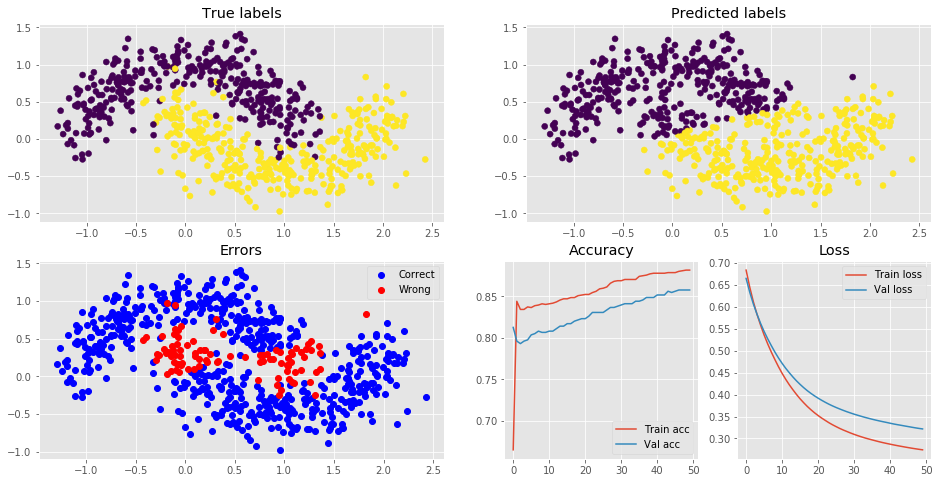

In [9]:
## Plotting the results
print('Training history', train_history.history.keys())

test_pred_prob = model.predict(x_test)
test_pred_labels = test_pred_prob[:,0]<0.5

fig = plt.figure(figsize=(16,8))
plt.subplot(221)
plt.title('True labels')
plt.scatter(x_test[:,0], x_test[:,1], c=targets_test)

plt.subplot(222)
plt.title('Predicted labels')
plt.scatter(x_test[:,0], x_test[:,1], c=test_pred_labels)

plt.subplot(223)
plt.title('Errors')
plt.plot(x_test[targets_test==test_pred_labels,0], x_test[targets_test==test_pred_labels,1], 'o', c='b', label='Correct')
plt.plot(x_test[targets_test!=test_pred_labels,0], x_test[targets_test!=test_pred_labels,1], 'o', c='r', label='Wrong')
plt.legend()

plt.subplot(247)
plt.title('Accuracy')
plt.plot(train_history.history['acc'], label='Train acc')
plt.plot(train_history.history['val_acc'], label='Val acc')
plt.legend(loc=4)

plt.subplot(248)
plt.title('Loss')
plt.plot(train_history.history['loss'], label='Train loss')
plt.plot(train_history.history['val_loss'], label='Val loss')
plt.legend()

plt.show()

# Assignments

 1) Notice the difference between the train accuracy and the validation accuracy and try to minimize this difference.
 
 2) Try to experiment by changing the  
 - number of layers
 - number of hidden units
 - optimizer
  - i.e. change '`sgd`' in the '`model.compile`' call. A list of Keras optimizers can be found [here](https://keras.io/optimizers/).
  